# Data Science Assigment by Harin Sanghirun

The goal of this assignment is to demonstrate to us your ability to manage a real-world data set, to communicate and contextualize summary statistics, and, most importantly, your creativity and analytical rigor in generating and testing hypotheses. The assignment is intentionally nonspecific and exploratory in nature. 

The data set at hand captures permits issued by the New York City Department Of Buildings (DOB), and can be accessed here. We strongly encourage you to merge the NYC permit data with other data sets to contextualize your investigation. Mindful of the time we are giving you to complete this assignment, we recommend somewhat narrowly focusing your investigation. We're looking for a document that summarizes your investigation and findings.


# Introduction

The problem we will be investigating in this assignment is the relationship between NYPD Complaint Report and the Department of Buildings permit issuance. Our hypothesis is that, the number of report should be in someway affected by the number of construction going on. The rationale is if there are more activities, then there should be more problems.

# Key Findings (TL;DR)

- We found that over the years, NYPD complaints decreases while building permit increases, which is the opposite of what we hypothesize.
- Plotting this data by zipcode and year reveals cluster of neighborhoods with 3 different characteristic

 1. Low development and Quiet (Rich?)
 2. Low development but lots of complaints (Poor?)
 3. High development and lots of complaints (Hip?)


- We found that over the past 10 years, neighborhoods defined by zipcode is relatively stable in this categorization, but 4 neighborhood have transition from one to another

 1. Upper West Side see more development.
 2. Upper East Side became quieter.
 3. The East Village see more development.
 4. Foley Square became problematic from a low development and quiet neighborhood. (Why?)

# Data Handling

Since the dataset is pretty large with 3.51 million rows in the permit dataset and over 6 million rows in the NYPD Complaint dataset, we will be creating a subsample so that our analysis does not take too much time. We create the sample by randomly selecting 1% of the rows from the data set. Furthermore, since different area of NYC could have very different characteristic, we choose to investigate only Manhattan.

In [2]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def skip(row):
    if row == 0: # preserve header
        return False
    return np.random.random() > 0.01

np.random.seed(1)
np.random.seed(1)
comp = pd.read_csv('NYPD_Complaint_Data_Historic.csv', skiprows=skip)
permit = pd.read_csv('DOB_Permit_Issuance.csv', skiprows=skip)

In [4]:
man_comp = comp[comp.BORO_NM == 'MANHATTAN']
man_permit = permit[permit.BOROUGH == 'MANHATTAN']

In [5]:
man_comp.shape

(14535, 35)

In [6]:
man_permit.shape

(14562, 60)

In [7]:
man_comp['RPT_DT'] = pd.to_datetime(man_comp['RPT_DT'])
man_permit['date'] = pd.to_datetime(man_permit['Issuance Date'])

report_by_year = man_comp.groupby(man_comp.RPT_DT.dt.year).count()['CMPLNT_NUM']
permit_by_year = man_permit.groupby(man_permit['date'].dt.year).count()['Lot']
counts = pd.concat([permit_by_year, report_by_year],axis=1).dropna()
counts.columns = ['permits', 'complaints']

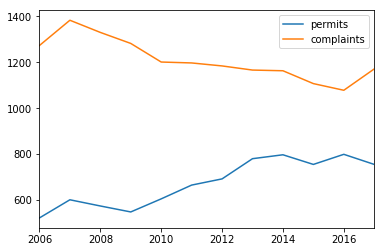

In [8]:
counts.plot();

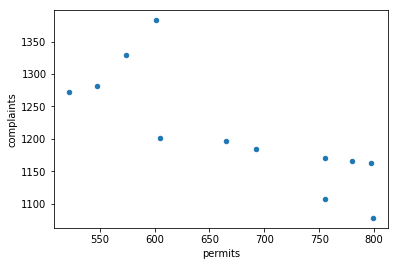

In [9]:
counts.plot.scatter('permits', 'complaints');

In [10]:
counts.corr()

,permits,complaints
permits,1.000000,-0.810817
complaints,-0.810817,1.000000


The scatterplot and the line chart shows there is a weak correlation between the two metrics, but there seems to be less complaints and there are more permits issued. This is unexpected.

We could drill down further to see if this effect exist at smaller region, like a zipcode. The problem is the NYPD data does not provide zipcode, just the latitude and longitude coordinate. First we will have to reverse geocoding to find the zipcode then we can drill down. We will be using `uszipcode` package for this.

In [11]:
from uszipcode import SearchEngine, Zipcode
search = SearchEngine(simple_zipcode=True)

man_comp = man_comp.dropna(subset=['Latitude', 'Longitude'])
man_permit = man_permit.dropna(subset=['Zip Code'])

man_comp['zipcode'] = man_comp.apply(lambda r: search.by_coordinates(r.Latitude, r.Longitude, radius=3, sort_by='dist')[0].zipcode, axis=1)

In [12]:
man_permit['zipcode'] = man_permit['Zip Code']
man_permit['year'] = man_permit['date'].dt.year

man_comp['year'] = man_comp['RPT_DT'].dt.year

In [13]:
permit_by_timeloc = man_permit.groupby(['year', 'zipcode']).count()[['Lot']].unstack()
permit_by_timeloc.fillna(0, inplace=True)
permit_by_timeloc = permit_by_timeloc['Lot']

complaints_by_timeloc = man_comp.groupby(['year', 'zipcode']).count()[['CMPLNT_NUM']].unstack()
complaints_by_timeloc = complaints_by_timeloc['CMPLNT_NUM']
complaints_by_timeloc.fillna(0, inplace=True)

In [14]:
permit_by_timeloc.columns = permit_by_timeloc.columns.to_native_types().astype(float).astype(int).astype(str)

In [15]:
# align zipcodes
man_zips = complaints_by_timeloc.columns.union(permit_by_timeloc.columns)

man_zips = sorted(man_zips)

years = complaints_by_timeloc.index.intersection(permit_by_timeloc.index)

complaints_by_timeloc = complaints_by_timeloc.reindex(columns=man_zips).fillna(0)
complaints_by_timeloc = complaints_by_timeloc.loc[years]

permit_by_timeloc = permit_by_timeloc.reindex(columns=man_zips).fillna(0)
permit_by_timeloc = permit_by_timeloc.loc[years]

In [16]:
zips = permit_by_timeloc.columns.intersection(complaints_by_timeloc.columns)

If we plot the scatter plot again but with each point representing each (year, zipcode) in the dataset, then the pattern is less obvious.

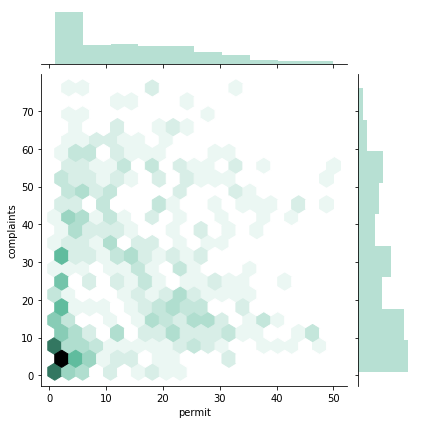

In [77]:
a = complaints_by_timeloc.stack().to_frame().reset_index()
b = permit_by_timeloc.stack().to_frame().reset_index()
b.columns = ['year', 'zipcode', 'permit']
a.columns = ['year', 'zipcode', 'complaints']
m = pd.merge(a,b,on=['year','zipcode'])
ax = sns.jointplot('permit', 'complaints', 
              data=m.query('complaints > 0 and permit > 0'), 
              kind="hex", color="#4CB391", 
              joint_kws=dict(gridsize=20))

The hexbin plot reveals that there could be some kind of clustering effect.

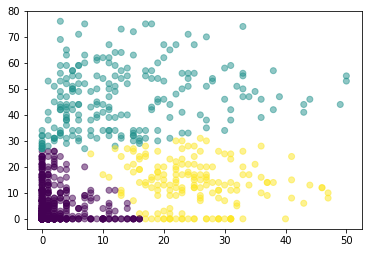

In [90]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=3).fit(m[['permit', 'complaints']])
m['c'] = pd.DataFrame(clf.predict(m[['permit', 'complaints']]))
plt.scatter(m['permit'], m['complaints'], c=m['c'], alpha=0.5);

In [91]:
clf.cluster_centers_

array([[ 1.41989664,  3.18604651],
       [13.49765258, 46.11737089],
       [24.96363636, 13.33939394]])

From the cluster values, we can interpret them as follow:
- Group 0 = low permit, low complaint = old and good neighborhood
- Group 1 = low permit, high complaint = old and bad neighborbood
- Group 2 = high permit, low complaint = new neighborhood

Let see how this looks in a map.

In [119]:
nyc_coord = [40.753, -73.9821]
mp = folium.Map(
    location=nyc_coord, zoom_start=12, 
    zoom_control=False,
    tiles='Stamen Toner',)

folium.Choropleth(geo_data = 'zipcode.geojson',
      data = m[m.year == 2017],
      columns = ['zipcode', 'c'],
      key_on = 'feature.properties.postalCode',
      fill_color = 'YlOrRd', 
      fill_opacity = 0.7, 
      line_opacity = 0.2,
).add_to(mp)
mp

The map shows the label for for year 2017. We can see that we have some data points that was mislabeled as Manhattan here. The red zones are the new and heavily developed neighborhood, the orange are old neighborhood with lots of problems. And the yellow are stable neighborhood with low level of development and problems. 

The zoning is pretty consistent with intuition. The upperwest side and midtown is the new neighborhood. The uppereast side and the financial district are the old ones with low level of development. While harlem and the space between midtown and financial district are old and problematic.

## Historical Development

One interesting thing to investigate is how these neighborhoods have transitioned through different groups. We can filter out only the zipcode where there is a change and plot them for year 2007 and 2017 to see the before and after.

In [129]:
mobility = m.groupby('zipcode').apply(lambda df: df.c.unique().shape[0])
mobility = mobility[mobility != 1].to_frame()
mobility.columns = ['moved_times']
mobility.reset_index(inplace=True)

moved_zips = []
for z in m.zipcode.unique():
    before = m[(m.zipcode == z) & (m.year == 2007)].c.values[0]
    after = m[(m.zipcode == z) & (m.year == 2017)].c.values[0]
    if before != after:
        moved_zips.append(z)
moved_zips

['10009', '10025', '10028', '10278']

In [157]:
nyc_coord = [40.753, -73.9821]
mp = folium.Map(
    location=nyc_coord, zoom_start=12, 
    zoom_control=False,
    tiles='Stamen Toner',)

folium.Choropleth(geo_data = 'zipcode.geojson',
      data = m[m.year == 2017],
      columns = ['zipcode', 'c'],
      key_on = 'feature.properties.postalCode',
      fill_color = 'YlOrRd', 
      fill_opacity = 0.7, 
      line_opacity = 0.2,
).add_to(mp)

for z in moved_zips:
    bound = SearchEngine().by_zipcode(zipcode=z)
    c = m[(m.zipcode == z) & (m.year==2007)].c.values[0]
    cmap = ['yellow', 'orange', 'red']
    
    folium.Circle(
        radius=300,
        location=[bound.lat, bound.lng],
        color=cmap[c],
        fill=False,
        fill_opacity=0.3
    ).add_to(mp)  
mp

The circle here represent the categorization of the area in 2007.

We can see that over the past 10 years, only 4 zipcode changes status. 
- The first being the upperwest got more popular and went from a relatively bad neighborhood to a one with lots of development. 
- The uppereast side also see change from a bad neighborhood to a peaceful one. 
- Third is that the east village become more popular
- Last is the the Foley Square, which is tiny dot near the financial district, which moved from a peaceful neighborhood to a problematic one.